# LRS3 Dataset Analysis

This notebook aims to get a better understanding of the data format provided in the dataset to make
preprocessing choices easier and better.
The dataset is available at [the homepage.](https://www.robots.ox.ac.uk/~vgg/data/lip_reading/lrs3.html)

## Imports

In [87]:
from pathlib import Path
from tqdm import tqdm
from more_itertools import ilen
from collections import defaultdict
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Dataset Size



In [95]:
data_dir = Path("/mnt/U/Datasets/lrs3pretrain/raw/pretrain")

In [96]:
speakers = list(data_dir.glob("*"))
utt_per_spk = {x.name: ilen(x.glob("*.mp4")) for x in speakers}
utterances = sum(utt_per_spk.values())
print(f"The dataset contains {utterances} utterances by {len(speakers)} speakers")

The dataset contains 118516 utterances by 5089 speakers


In [97]:
min_spk, min_amount = min(utt_per_spk.items(), key=lambda x: x[1])
max_spk, max_amount = max(utt_per_spk.items(), key=lambda x: x[1])
gt5 = sum([1 for v in utt_per_spk.values() if v > 5])
print(f"Lowest amount of utterances: {min_amount} by {min_spk}")
print(f"Highest amount of utterances: {max_amount} by {max_spk}")
print(f"Total speakers with > 5 utterances: {gt5}")

Lowest amount of utterances: 1 by 0e3lCYwtm9o
Highest amount of utterances: 105 by KQEWc3LVfyc
Total speakers with > 5 utterances: 4684


## Number of Speakers with `n` utterances


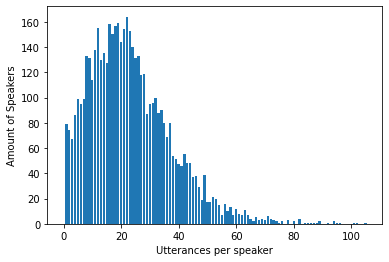

In [53]:
spks_per_utt = np.zeros((106))
for spk in utt_per_spk.values():
    spks_per_utt[spk] += 1
plt.bar(list(range(106)), spks_per_utt)
plt.xlabel("Utterances per speaker")
plt.ylabel("Amount of Speakers")
plt.savefig("./spks_per_utt_amount.pdf")
plt.show()

## Utterance Lengths

In [98]:
def utt_lengths(utt_file):
    with utt_file.open() as f:
        lines = f.readlines()
        words = [x.split(" ")[0] for x in lines[4:]]
        length = float(lines[-1].split(" ")[2])
    return words, length

In [104]:
all_words = defaultdict(lambda: 0)
total_length = 0
spk_lengths = np.zeros((len(speakers)))
utt_lengths_list = np.zeros((60))
longer = 0
shortest = 10
longest = 0
for i, speaker in enumerate(tqdm(speakers)):
    for text in speaker.glob("*.txt"):
        words, length = utt_lengths(text)
        for word in words:
            all_words[word] += 1
        total_length += length
        spk_lengths[i] += length
        if length < shortest:
            shortest = length
        if length > longest:
            longest = length
        seconds = int(np.round(length))
        if seconds < len(utt_lengths_list):
            utt_lengths_list[seconds] += 1
        else:
            longer += 1
print(longer)
print(shortest)
print(longest)

100%|██████████| 5089/5089 [00:16<00:00, 317.65it/s]

1134
0.66
668.36


## Audio length per speaker

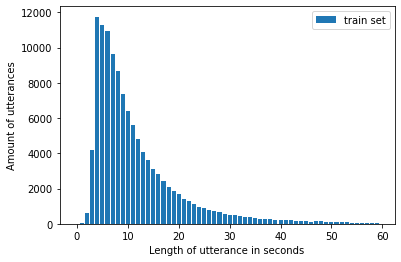

In [102]:
plt.bar(list(range(len(utt_lengths_list))), utt_lengths_list, label="train set")
plt.ylabel("Amount of utterances")
plt.xlabel("Length of utterance in seconds")
plt.legend()
plt.savefig("./utterance_lengths.pdf")
plt.show()

## Text analysis

In [41]:
amount_words = sum(all_words.values())
times_spoken = list(sorted(all_words.items(), key=lambda x: x[1], reverse=True))

In [42]:
print(f"A total of {amount_words} words are spoken.")
print(f"Total audio length is {(total_length/3600):.2f} hours.")
print(f"Average utterance length is {(total_length/utterances):.2f} seconds.")
print(f"Average audio per speaker is {(total_length/len(speakers)/60):.2f} minutes")
print(f"Each speaker says {(amount_words/len(speakers)):.2f} unique words on average.")
print("The top ten most spoken words are:")
for i, (word, amount) in enumerate(times_spoken[:10]):
        print(f"  {i+1}: {word} spoken {amount} times")

A total of 0 words are spoken.
Total audio length is 1.98 hours.
Average utterance length is 5.39 seconds.
Average audio per speaker is 0.29 minutes
Each speaker says 0.00 unique words on average.
The top ten most spoken words are:


In [9]:
words_spoken_once = [x for x, y in all_words.items() if y == 1]
print(f"{len(words_spoken_once)} words are only spoken once.")
print("Here are some examples:")
for word in words_spoken_once[:10]:
    print(f"  {word}")

18674 words are only spoken once.
Here are some examples:
  REGAINS
  VIBRANCE
  GEMMA
  EUTHANASIA
  BARNABY
  MIGHTIER
  OAU
  SEB
  HEALTHFUL
  ANIMATES


## Sentiment analysis
This section uses the [Transformers](https://github.com/huggingface/transformers) natural language processing library for sentiment analysis.

In [10]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', device=0)

In [11]:
def get_sentence(utt_file):
    with utt_file.open() as f:
        lines = f.readlines()
        sentence = lines[0].split("Text: ")[1].strip()
    return sentence

In [12]:
batch_size = 8
sentences = {}
for i, speaker in enumerate(tqdm(speakers)):
    speaker_sentences = []
    for text in speaker.glob("*.txt"):
        sent = get_sentence(text)
        if len(sent) < 1000:
            speaker_sentences.append(sent)
    sentiments = []
    for i in range(math.ceil(len(speaker_sentences)/batch_size)):
        sentiments += classifier(speaker_sentences[i*batch_size:(i+1)*batch_size])
    for i, sentence in enumerate(speaker_sentences):
        sentences[sentence] = sentiments[i]

100%|██████████| 5089/5089 [03:56<00:00, 21.52it/s]


In [18]:
pos = 0
neg = 0
total = 0
for sentence, sentiment in sentences.items():
    if sentiment["label"] == "POSITIVE":
        pos += 1
    else:
        neg += 1
    total += sentiment["score"]
average = total/utterances

In [22]:
print(f"The dataset has {pos} positive and {neg} negative utterances.")
print(f"The average confidence is {average:.5f}")
print(f"{utterances-neg-pos} utterances were skipped because they were too long.")

The dataset has 57114 positive and 60335 negative utterances.
The average confidence is 0.94717
1067 utterances were skipped because they were too long.


In [33]:
most_pos = list(sorted([(t, s) for t, s in sentences.items() if s["label"] == "POSITIVE"], key=lambda x: x[1]["score"], reverse=True))
print(f"The most positive sentences are:")
for t, s in most_pos[:10]:
    print(f"  {t.strip()} --> {s['score']:.6f}")

The most positive sentences are:
  COLOR LAUGHTER AND OF COURSE MUSIC TO REMEMBER ME BY THANK YOU --> 0.999893
  THIS WONDER OF NATURE FLOURISH AND PROSPER THANK YOU --> 0.999892
  GATHER IN LARGE GROUPS THAT ARE AMONG THE MOST WONDERFUL SPECTACLES IN THE NATURAL --> 0.999891
  ALONE WE ARE SMART TOGETHER WE ARE BRILLIANT --> 0.999891
  SHARE OF OURSELVES TO BE VULNERABLE AND IT'S VERY EXCITING SO THANK YOU --> 0.999891
  A MORE LIVABLE AND A MORE DELICIOUS FUTURE THANK YOU --> 0.999891
  BY THE RAPIDITY OF THIS LEARNING THEY ARE QUITE RIGHTLY AMAZED AND DELIGHTED BY THEIR CHILDREN'S CLEVERNESS --> 0.999891
  AND HE HAS A REALLY WONDERFUL TURN OF PHRASE AND WHAT A SENSE OF VISION THAT HE --> 0.999891
  LIKE FASHIONABLY HIP AND REALLY COOL AND GREAT --> 0.999890
  FORMS MOST BEAUTIFUL AND MOST WONDERFUL AND I LIKE TO THINK HE --> 0.999890


In [34]:
most_pos = list(sorted([(t, s) for t, s in sentences.items() if s["label"] == "NEGATIVE"], key=lambda x: x[1]["score"], reverse=True))
print(f"The most negative sentences are:")
for t, s in most_pos[:10]:
    print(f"  {t.strip()} --> {s['score']:.6f}")

The most negative sentences are:
  WHERE WE'RE GOING YOU KNOW WHY IS IT NOT DONE A LOT OF IT IS JUST COMPUTING'S KIND OF A MESS YOU KNOW YOUR COMPUTER DOESN'T KNOW WHERE YOU ARE IT DOESN'T KNOW WHAT YOU'RE DOING --> 0.999821
  CONGESTION WELL AS YOU'VE HEARD CONGESTION IS MAJOR NUISANCE TO ALL OF US LOSS OF TIME MEANS LOSS OF PRODUCTION AND LOSS OF TIME THAT WE COULD USE TO DO MORE FUN THINGS WELFARE --> 0.999821
  TO ME IT'S REALLY AN UGLY UNIVERSE IT'S STUPIDLY CONSTRUCTED IT'S GOT WAY TOO MANY ARBITRARY COUPLING CONSTANTS AND MASS RATIOS AND SUPERFLUOUS FAMILIES OF ELEMENTARY PARTICLES AND WHAT THE HELL IS DARK ENERGY IT'S --> 0.999821
  IT'LL BE RAINY I'LL GET DEPRESSED THE WHOLE THING WILL BE A HUGE WASTE OF TIME NUMBER TWO I'LL MISS A LETTER FROM THE IRS AND I'LL GET AUDITED OR RAIDED OR SHUT DOWN OR SOME --> 0.999817
  DOING A FAILED PROJECT AND SO LIKE I SAID I THINK THE IDEA TO ACTION STRATEGY NEEDS A PROCESS FOR US TO GO THROUGH OTHERWISE WE JUST HAVE THESE RANDOM IDEAS GOING